# Predicting Catalog Demand



## Business and Data Understanding

A company manufactures and sells high-end home goods. Last year it sent out its first print catalogue and is preparing to send out the new catalog for the year. From the mailing list the company has 250 new customers they would like to send the catalogue to. The company wants to determine how much profit can be expected from sending the catalogue to these customers. Management has set a profit threshold of $10,000. If the expected profits meet or exceed this threshold, then the catalogue will be sent.

Key Decisions:

1. **What decisions needs to be made?**

    Whether or not the print catalog should be sent to the 250 new customers within the mailing list. This is dependent on whether the estimated profit meets and/or exceeds \\$10,000. If the value is below \\$10,000, the catalog will not be sent to those 250 customers.


2. **What data is needed to inform those decisions?**
    * For each of the 250 new customers we will need to estimate the average sale amount.
    * Then the expected revenue can be calculated by multiplying average sale amount with the score value metric, which acts as the probability the customer will respond to the catalog. 
    * The average gross margin is 0.5. The price of printing and sending each catalog is $6.50 so this is then subtracted from the expected revenue times the average gross margin. 
    * These values are then summed to give the final expected profits.
    
$$Expected Profit = \sum_{i=1}^{n} Average Sale Amount_i * Score_i * Gross Margin - Cost$$

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from patsy import dmatrices

# Load datasets
cust_df=pd.read_excel('data/p1-customers.xlsx')
mail_df=pd.read_excel('data/p1-mailinglist.xlsx')
# Minor cleaning of variables
cust_df[['ZIP','Store_Number']] = cust_df[['ZIP','Store_Number']].astype('str')
mail_df[['ZIP','Store_Number']] = mail_df[['ZIP','Store_Number']].astype('str')

display(cust_df.head())
display(mail_df.head())

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


## Analysis, Modeling, and Validation

Some obvious variables we'll want to eliminate are: `Name`, `Customer_ID`, `Address`and `State` (all customers are from CO). `ZIP` will not be used in the model as there were 86 distinct zip codes in the customer list.

The variables chosen were `Avg_Num_Products_Purchased` and `Customer_Segment`.

**Average Number of Products Purchased**

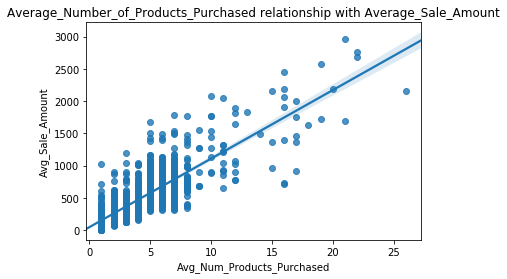

In [20]:
sns.regplot(x='Avg_Num_Products_Purchased',y='Avg_Sale_Amount', data=cust_df)
plt.title('Average_Number_of_Products_Purchased relationship with Average_Sale_Amount')
plt.show()

The above scatterplot clearly shows that as the average number of products, the higher the average sale amount tends to be. This makes intuitive sense as the more products bought increases the sale total.

**Customer Segments**

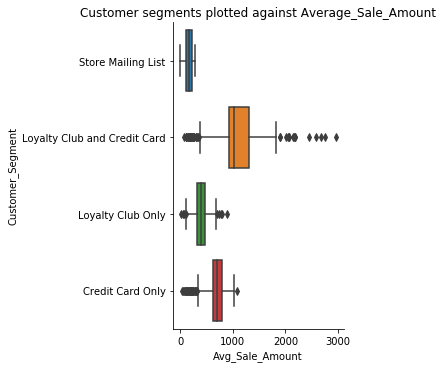

In [38]:
sns.catplot(y='Customer_Segment',x='Avg_Sale_Amount', orient='h', kind="box", data=cust_df)
plt.title('Customer segments plotted against Average_Sale_Amount');

Customers segmented under **Loyalty Club and Credit Card** tend to have the highest average sale amounts, while those in **Store Mailing List** tend to have the lowest among the 4 groups. This suggests that the customer segments may have some correlation with average sale amount and can be used as a significant predictor variable.

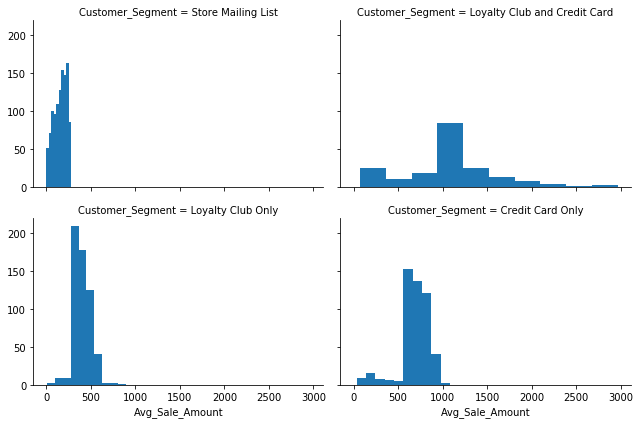

In [110]:
g = sns.FacetGrid(cust_df, col='Customer_Segment',col_wrap=2, aspect=1.5)
g.map(plt.hist, 'Avg_Sale_Amount');
d = {}
for segment in cust_df['Customer_Segment'].unique():
    metrics = cust_df['Avg_Sale_Amount'][cust_df['Customer_Segment'] == segment].describe()
    d[segment] = (metrics['50%'], metrics['std'], int(metrics['count']))
    #print(f"median average_sale_amount for {segment}: ${round(med,2)}")

In [111]:
pd.DataFrame.from_dict(d, orient='index', columns=['median','std','count'])

,median,std,count
Store Mailing List,166.915,71.901346,1108
Loyalty Club and Credit Card,1015.655,537.836227,194
Loyalty Club Only,384.760,100.789531,579
Credit Card Only,698.600,170.390092,494


It can be gathered from the above graphs and table that, customers in the Loyalty Club and Credit Card segment, tend to spend the most, the median value was **\\$1015** this group also had the highest variance in spending with a standard deviation of **537**. The other groups spent less on average and the differences in spending were much less, and had less variance.

With this categorical variable the model should be able to take into account the customer segment when predicting for each new customer in the mailing list. It can be expected that the linear model will predict that customers in the `Store Mailing List` will usually spend less than those in other segments.

### Building the linear Model

Variable we are predicting for:
* We are predicting for the variable: `Avg_Sale_Amount`, a continuous variable.

Type of model:
* The dependent variable is monetary and thus continuous, it makes sense to use a **OLS Regression model**. The hypothesis is that that predictor variables, `Avg_Num_Products_Purchased`, `Customer_Segment` have a linear relationship with `Avg_Sale_Amount`.



In [113]:
# Get the dependent variable
y = cust_df['Avg_Sale_Amount']
# Get the predictor variables 
choice = ['Customer_Segment','Avg_Num_Products_Purchased']
# Dummify variables
X = pd.get_dummies(cust_df[choice], columns=['Customer_Segment'], drop_first=True)
X = sm.add_constant(X)
# Fit the linear model
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        21:21:21   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

From the results, All of the chosen variables are statistically significant. (P-values reported as zero)

The Adjusted R-squared is 0.837, the rule of thumb is that a value higher than 0.7 signifies a good model. In this case over 80% of the variance is explained by the model.

$$\large Y = 303.464 + 66.976 \cdot AvgNumProductsPurchased - 149.356 \cdot CustomerSegmentLoyaltyClubOnly + 281.839 \cdot CustomerSegmentLoyaltyClubandCreditCard - 245.418 \cdot  CustomerSegmentStoreMailingList$$

Note: The model constant takes into account the segment *Credit Card Only*

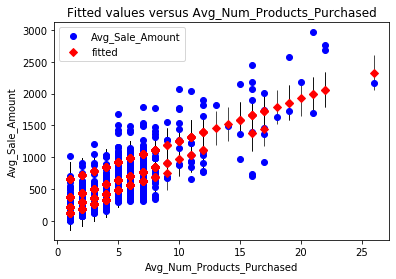

In [129]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 1, ax=ax)
plt.show()

### Prediction

With the model we can now predict the average sale amounts for the new customers in the mailing list. In the mailing list dataset there are some new variables: `Score_No` and `Score_Yes`. These act as the probability the customer will make the purchase. Thus 

`Score_Yes` * `Predicted_Avg_Sale_Amount` 

will give us the expected revenue. 

In [138]:
m_variables = ['Customer_Segment', 'Avg_Num_Products_Purchased']
probs = mail_df[['Score_No','Score_Yes']]
X_mail = mail_df[m_variables]
# Get dummy variables
X_mail = pd.get_dummies(X_mail, columns=['Customer_Segment'], drop_first=True)
X_mail = sm.add_constant(X_mail)
# Build final dataframe 'mail_dff'
mail_dff = mail_df[['Customer_Segment','Avg_Num_Products_Purchased','Score_No','Score_Yes']].copy()
mail_dff['Predicted_Avg_Sale_Amount'] = res.predict(X_mail)
mail_dff['Expected_Revenue'] = mail_dff['Predicted_Avg_Sale_Amount'] * mail_dff['Score_Yes']
mail_dff.head()

,Customer_Segment,Avg_Num_Products_Purchased,Score_No,Score_Yes,Predicted_Avg_Sale_Amount,Expected_Revenue
0,Loyalty Club Only,3,0.694964,0.305036,355.036364,108.298804
1,Loyalty Club and Credit Card,6,0.527275,0.472725,987.159466,466.654501
2,Loyalty Club Only,7,0.421118,0.578882,622.941184,360.609345
3,Loyalty Club Only,2,0.694862,0.305138,288.060159,87.898046
4,Loyalty Club Only,4,0.612294,0.387706,422.012569,163.616744


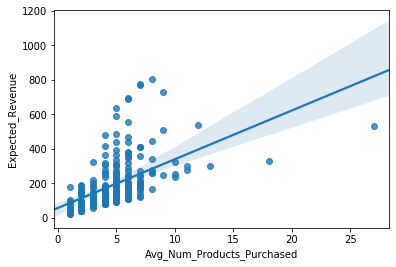

In [142]:
#sns.regplot(x='Avg_Num_Products_Purchased',y='Predicted_Avg_Sale_Amount', data=mail_dff)
sns.regplot(x='Avg_Num_Products_Purchased',y='Expected_Revenue', data=mail_dff)
plt.title('');

## Estimating Profits

In [117]:
gross_margin = 0.5 # average gross margin
cost = 6.50 # Cost of printing and sending catalog
mail_dff['Expected_Profit'] = (mail_dff['Expected_Revenue'] * gross_margin) - cost
expected_profit = round(mail_dff['Expected_Profit'].sum(),2)
print(f"From the model, we can expect a total profit of: ${expected_profit}")

From the model, we can expect a total profit of: $21987.44


## Presentation/Visualization

1. What is the recommendation? Should the company send the catalog to these customers?

Recommendation: My recommendation is that yes, the company should send the catalog.

2. How did you come up with the recommendation?

 This exceeds the threshold of \\$10,000 set my management by more than \\$10,000.

3. What is the expected profit from the new catalog?

The model estimates that if the new catalog is sent, the total profit will be approxmiately \\$21K.